# Group 3 Optimization Project - P-Median Model for JB Hunt Transportation

## Goals of our model
Given our 9 shipping facilities (origins) and 39 destinations (customers/demanders), we want to select 5 optimal locations to minimize distance bewtween shipping facilities and destinations. 

Demand was used as a weight in our model, in order for the model to take into account the distance between points, providing accurate, and optimal results.

## Installing Necessary Packages & Data

In [83]:
# !pip install -q pyomo
# !pip install cbc
# !pip install glpk
# !pip install pyomo

In [84]:
# Load packages
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import pyomo.environ as pyo
from sklearn.cluster import KMeans
import sys
import os
from pyomo.environ import SolverFactory
from geopy.geocoders import Nominatim
import matplotlib.patches as mpatches

In [85]:
# Importing data, change path as needed
data = pd.read_excel('/Users/noascharf/Library/CloudStorage/OneDrive-Personal/Data Science/Spring 2024/DASC 3203 - Optimization/Project/bluestardata_final.xlsx')

## Data Filtering

We decided to focus in on one SCAC to narrow our analysis, and we chose JB Hunt as our target SCAC.

In [86]:
# Defining target scac for filtering
target_scac = 'HJBT'

# Define columns to drop
cols_to_drop = ['ShipDate', 'Weight', 'Volume', 'Freight Paid', 'On Time', 'Delivered Complete', 'Damage Free', 'Billed Accurately']

# Drop columns
drop_data = data.drop(columns=cols_to_drop)

# Filtered data
hjbt_data = drop_data[drop_data['SCAC'] == target_scac]

# Print data
hjbt_data.head()

,SCAC,OriginCity,OriginState,OriginLocation,OriginLongitude,OriginLatitude,OriginZip,OriginType,DestCity,DestState,DestLatitude,DestLongitude,DestLocation,DestZip,DestinationType
17895,HJBT,ATLANTA,GA,"ATLANTA, GA",-84.39,33.75,30269,Supplier,HAMILTON,OH,39.4,-84.56,"HAMILTON, OH",45011,DC
18020,HJBT,ATLANTA,GA,"ATLANTA, GA",-84.39,33.75,30269,Supplier,HAMILTON,OH,39.4,-84.56,"HAMILTON, OH",45011,DC
18021,HJBT,ATLANTA,GA,"ATLANTA, GA",-84.39,33.75,30269,Supplier,HAMILTON,OH,39.4,-84.56,"HAMILTON, OH",45011,DC
18116,HJBT,ATLANTA,GA,"ATLANTA, GA",-84.39,33.75,30269,Supplier,HAMILTON,OH,39.4,-84.56,"HAMILTON, OH",45011,DC
18214,HJBT,ATLANTA,GA,"ATLANTA, GA",-84.39,33.75,30269,Supplier,HAMILTON,OH,39.4,-84.56,"HAMILTON, OH",45011,DC


## Exploratory Data Analysis

In [87]:
num_origins = hjbt_data['OriginCity'].nunique()
num_dest = hjbt_data['DestCity'].nunique()

print(f"The total amount of origin facilities is {num_origins}")
print(f"The total amount of unique destination cities is {num_dest}")

The total amount of origin facilities is 9
The total amount of unique destination cities is 39


In [88]:
hjbt_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2186 entries, 17895 to 38501
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SCAC             2186 non-null   object 
 1   OriginCity       2186 non-null   object 
 2   OriginState      2186 non-null   object 
 3   OriginLocation   2186 non-null   object 
 4   OriginLongitude  2186 non-null   float64
 5   OriginLatitude   2186 non-null   float64
 6   OriginZip        2186 non-null   int64  
 7   OriginType       2186 non-null   object 
 8   DestCity         2186 non-null   object 
 9   DestState        2186 non-null   object 
 10  DestLatitude     2186 non-null   float64
 11  DestLongitude    2186 non-null   float64
 12  DestLocation     2186 non-null   object 
 13  DestZip          2186 non-null   int64  
 14  DestinationType  2186 non-null   object 
dtypes: float64(4), int64(2), object(9)
memory usage: 273.2+ KB


In [89]:
hjbt_data.isnull().sum()

SCAC               0
OriginCity         0
OriginState        0
OriginLocation     0
OriginLongitude    0
OriginLatitude     0
OriginZip          0
OriginType         0
DestCity           0
DestState          0
DestLatitude       0
DestLongitude      0
DestLocation       0
DestZip            0
DestinationType    0
dtype: int64

In our data, we have 9 origin (supplier) facilities, and we have 39 destination (demand) cities/facilities. In our model, we will use these 9 origins as potential facilities (medians), and we will choose 5 optimal locations in order to minimize distance between medians and destinations.

In [90]:
# removing unnecessary columns that i dont want
hjbt_data = hjbt_data[['SCAC', 'OriginCity', 'OriginState', 'OriginLongitude', 'OriginLatitude', 'DestCity', 'DestState', 'DestLatitude', 'DestLongitude']]

hjbt_data.head()

,SCAC,OriginCity,OriginState,OriginLongitude,OriginLatitude,DestCity,DestState,DestLatitude,DestLongitude
17895,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56
18020,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56
18021,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56
18116,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56
18214,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56


Since there were many columns in our data, we decided to narrow it down to just the columns that were necessary for visualizations and building our model.

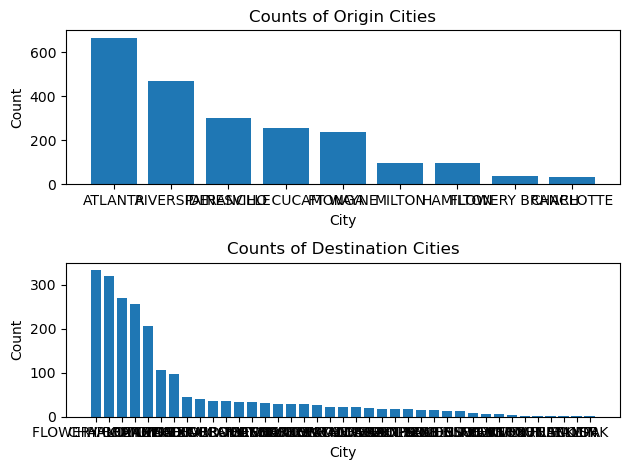

In [91]:
# Counts graphs
origin_counts = hjbt_data['OriginCity'].value_counts()
dest_counts = hjbt_data['DestCity'].value_counts()

# Creating subplot with 2 graphs
fig, axs = plt.subplots(2)

# Plot the counts of origin cities
axs[0].bar(origin_counts.index, origin_counts.values)
axs[0].set_title('Counts of Origin Cities')
axs[0].set_xlabel('City')
axs[0].set_ylabel('Count')

# Plot the counts of destination cities
axs[1].bar(dest_counts.index, dest_counts.values)
axs[1].set_title('Counts of Destination Cities')
axs[1].set_xlabel('City')
axs[1].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

These graphs are fairly messy, because there are so many origins and destinations. So, we also printed the counts of the shipments going out of origin cities, and the demand of the destinations.

In [92]:
# Printing origin counts to see shipments & dest counts (to see demand)
print(origin_counts)
print('\n')
print(dest_counts)

OriginCity
ATLANTA             666
RIVERSIDE           467
PAINESVILLE         300
RANCHO CUCAMONGA    257
FT WAYNE            237
MILTON               96
HAMILTON             95
FLOWERY BRANCH       36
CHARLOTTE            32
Name: count, dtype: int64


DestCity
FLOWERY BRANCH       333
CHARLOTTE            319
HAMILTON             270
OMAHA                255
MILTON               205
RENO                 107
WICHITA               97
SAFFORD               45
RANCHO CUCAMONGA      40
RIVERSIDE             36
CARROLLTON            35
ELK GROVE VILLAGE     34
FRESNO                33
HAYWARD               32
GREENSBORO            30
FENTON                29
FORT WAYNE            29
MILL HALL             27
CHEEKTOWAGA           23
SIOUX FALLS           22
CHICOPEE              22
MINNEAPOLIS           20
PHOENIX               18
GREENFIELD            17
HOPKINS               17
SALT LAKE CITY        16
GOLDEN                16
ROBINSON              14
SOMERSWORTH           13
BUFFALO    

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/1880763758.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Latitude'] = us_map['geometry'].centroid.y
/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/1880763758.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Longitude'] = us_map['geometry'].centroid.x


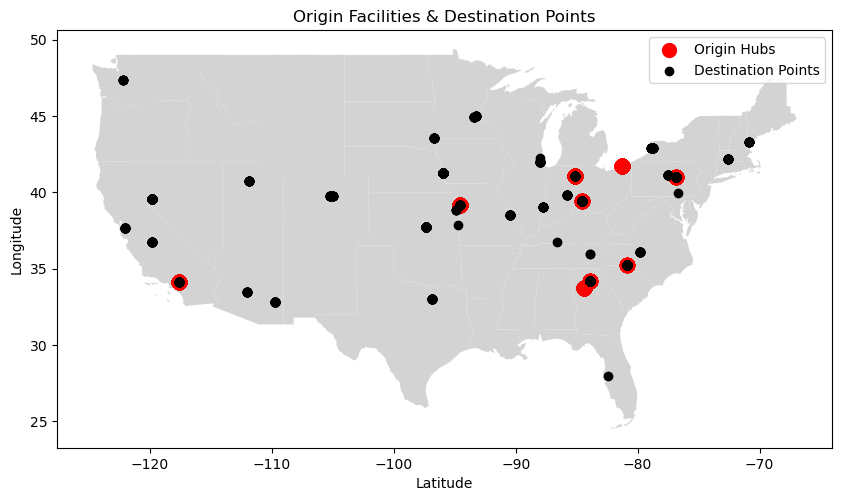

In [134]:
# Load US shapefile, change file path as needed
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

# Extract latitude and longitude from the geometry
us_map['Latitude'] = us_map['geometry'].centroid.y
us_map['Longitude'] = us_map['geometry'].centroid.x


fig, ax = plt.subplots(figsize=(10, 6))
us_map.plot(ax=ax, color='lightgrey')
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

# Scatter plot your data points
ax.scatter(hjbt_data['OriginLongitude'], hjbt_data['OriginLatitude'], color='red', label='Origin Hubs', s = 100)
ax.scatter(hjbt_data['DestLongitude'], hjbt_data['DestLatitude'], color='black', label='Destination Points')

ax.legend()

plt.title('Origin Facilities & Destination Points')
plt.show()

In [94]:
# Create Point objects for the origin and destination points
hjbt_data['OriginPoint'] = hjbt_data.apply(lambda row: Point(row['OriginLongitude'], row['OriginLatitude']), axis = 1)
hjbt_data['DestPoint'] = hjbt_data.apply(lambda row: Point(row['DestLongitude'], row['DestLatitude']), axis = 1)

# Create a LineString object that connects the origin and destination points
hjbt_data['geometry'] = hjbt_data.apply(lambda row: LineString([row['OriginPoint'], row['DestPoint']]), axis = 1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(hjbt_data, geometry= 'geometry')

# Make GeoDataFrame for Origin and Destination separately
gdf_origin = gpd.GeoDataFrame(hjbt_data, geometry= 'OriginPoint')
gdf_destination = gpd.GeoDataFrame(hjbt_data, geometry='DestPoint')

# hjbt_data.head()

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/669027565.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


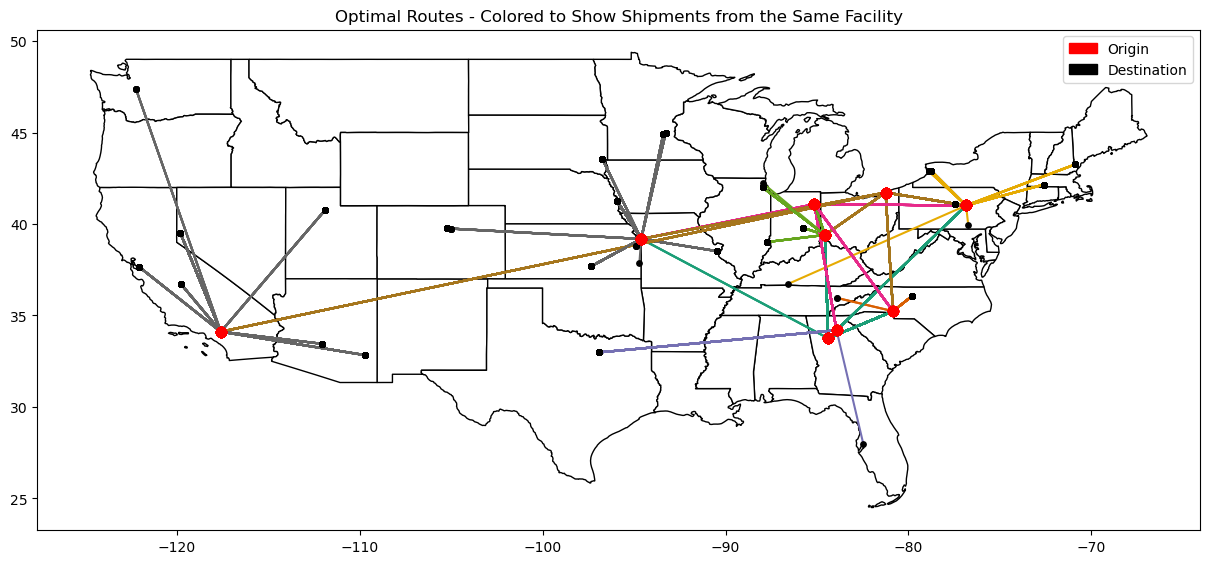

In [95]:
# get geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load US shapefile
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

ax = us_map.plot(color='white', edgecolor='black', figsize=(15, 10))
gdf_origin.plot(ax=ax, color='red', markersize=50, zorder = 3)
gdf_destination.plot(ax=ax, color = 'black', markersize=15, zorder =2)
gdf.plot(ax=ax, column = 'OriginCity', cmap = 'Dark2', zorder = 1)

# Create legend
red_patch = mpatches.Patch(color='red', label='Origin')
black_patch = mpatches.Patch(color='black', label='Destination')
ax.legend(handles=[red_patch, black_patch])

plt.title('Optimal Routes - Colored to Show Shipments from the Same Facility')
plt.show()

As seen above, there is a lot going on, and even cross country shipments going on. Let's try and optimize these locations in order to reach our goal (minimize distance between optimal supplier facilities and the demand destinations).

In [96]:
# Look at the data frame
gdf.info()

# Just adding a space between to look more clean
print('\n')
print(f'The shape of the GeoDataFrame is:', gdf.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2186 entries, 17895 to 38501
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SCAC             2186 non-null   object  
 1   OriginCity       2186 non-null   object  
 2   OriginState      2186 non-null   object  
 3   OriginLongitude  2186 non-null   float64 
 4   OriginLatitude   2186 non-null   float64 
 5   DestCity         2186 non-null   object  
 6   DestState        2186 non-null   object  
 7   DestLatitude     2186 non-null   float64 
 8   DestLongitude    2186 non-null   float64 
 9   OriginPoint      2186 non-null   object  
 10  DestPoint        2186 non-null   object  
 11  geometry         2186 non-null   geometry
dtypes: float64(4), geometry(1), object(7)
memory usage: 222.0+ KB


The shape of the GeoDataFrame is: (2186, 12)


## Begin Conversion to GeoDataFrame

In order to calculate distances, and create geo points using our lat and long points, conversion to a GeoDataFrame is necessary.

In [97]:
# implement coordinate reference system just to make sure
gdf.crs = {'init': 'epsg:4326'}

# gdf.head()

/Users/noascharf/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [98]:
# Calculate Haversine distance to add to dataframe

def haversine_distance(linestring):
    # Ensure the input is a LineString
    if not isinstance(linestring, LineString):
        raise ValueError("Input should be a LineString")

    # Get the coordinates of the points
    coords = list(linestring.coords)

    # Define the Haversine function
    def haversine(coord1, coord2):
        R = 3958.8  # Radius of the Earth in miles
        lat1, lon1 = math.radians(coord1[1]), math.radians(coord1[0])
        lat2, lon2 = math.radians(coord2[1]), math.radians(coord2[0])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        return R * c

    # Calculate the Haversine distance
    distance = 0
    for i in range(1, len(coords)):
        distance += haversine(coords[i-1], coords[i])

    return distance

In [99]:
# Haversine distance for model dictionary
def haversine_dist(coord1, coord2):
    R = 3958.8  # Radius of the Earth in miles
    lat1, lon1 = math.radians(coord1[1]), math.radians(coord1[0])
    lat2, lon2 = math.radians(coord2[1]), math.radians(coord2[0])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

In [100]:
# Adding haversine distance to gdf
gdf['haversine_distance'] = gdf['geometry'].apply(haversine_distance)

# gdf.head()

In [101]:
gdf_destination["DestPoint"].x
gdf_destination["DestPoint"].y

# Doing stuff for demand points
# Extracting  x and y from destination points
gdf_destination['x'] = gdf_destination['DestPoint'].apply(lambda geom: geom.x)
gdf_destination['y'] = gdf_destination['DestPoint'].apply(lambda geom: geom.y)

# Create demand point col
gdf['demand_points'] = list(zip(gdf_destination['x'], gdf_destination['y']))

# gdf.head()

In [102]:
# Sort data to be in alphabetical order by destination (demand)
gdf_alphabetical = gdf.sort_values(by='DestCity')

# Assigning demand column
gdf_alphabetical['DestDemand'] = gdf_alphabetical.groupby('DestCity')['DestCity'].transform('count')

# gdf_alphabetical.head()

## Building Pyomo Model (P-Median)

The objective function for our model is:

* $\text{{min}} \sum_{{i \in I}} \sum_{{j \in J}} d_{ij} x_{ij} a_j$

The constraints of the model are:

* $\sum_{i\in I } x_{ij} = 1$	for $\forall j \in J$
* $x_{ij} \leq y_i$ for $ \forall i \in I, \forall j \in J$ 
* $\sum_{i\in I } y_i = p$

Where:
- $I$ represents an index referencing nodes of the network as potential facility sites
- $J$ represents an index referencing nodes of the network as demands
- $d_{ij}$ represents the distance between origin $i$ and destination $j$
- $a_j$ represents the demand from destination $j$
- $p$ represents the number of facilities to be located
- $x_{ij}$ represents if origin $i$ was assigned to a destination $j$ (binary variable)
- $y_i$ represents whether or not $i$ has been selected as a facility (binary variable)


In [103]:
from pyomo.environ import *

# assign new df to prevent messing up and drop geometry
df = pd.DataFrame(gdf_alphabetical.drop(columns=['geometry']))  # Assuming geometry is not needed here

# Creating dicttionary for longitudes and latitudes for origins and destinations
destloc_dict = {row['DestCity'] : (row['DestLongitude'],row['DestLatitude'])for index, row in df.iterrows()}
origloc_dict = {row['OriginCity'] : (row['OriginLongitude'],row['OriginLatitude'])for index, row in df.iterrows()}

# Create dictionaries for distances and demands
demand_dict = {row['DestCity']: row['DestDemand'] for index, row in df.iterrows()}
distance_dict = {(orig,dest):haversine_dist(origloc_dict[orig],destloc_dict[dest]) for orig in origloc_dict.keys() for dest in destloc_dict.keys()}

# print(destloc_dict)
# print(origloc_dict)
# df.head()
# print(distance_dict)
# print(distance_dict)

In [104]:
#Define a concrete model
model = pyo.ConcreteModel()

In [105]:
# Clear and print to be sure
model.clear()

model.pprint()

0 Declarations: 


In [106]:
# Defining origins and destinations for model
origins = df['OriginCity'].unique()
destinations = df['DestCity'].unique()

model.I = Set(initialize=origins)  # Set of origins
model.J = Set(initialize=destinations)  # Set of destinations

# printing models
model.I.pprint()
model.J.pprint()

I : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    9 : {'MILTON', 'FLOWERY BRANCH', 'ATLANTA', 'PAINESVILLE', 'FT WAYNE', 'RIVERSIDE', 'HAMILTON', 'RANCHO CUCAMONGA', 'CHARLOTTE'}
J : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :   39 : {'BUFFALO', 'CARROLLTON', 'CHARLOTTE', 'CHEEKTOWAGA', 'CHICOPEE', 'DENVER', 'ELK GROVE VILLAGE', 'FENTON', 'FLOWERY BRANCH', 'FORT SCOTT', 'FORT WAYNE', 'FRANKLIN', 'FRESNO', 'GOLDEN', 'GREENFIELD', 'GREENSBORO', 'HAMILTON', 'HAYWARD', 'HOPKINS', 'KENT', 'KNOXVILLE', 'MILL HALL', 'MILTON', 'MINNEAPOLIS', 'NEW CENTURY', 'OMAHA', 'PHOENIX', 'RANCHO CUCAMONGA', 'RENO', 'RIVERSIDE', 'ROBINSON', 'SAFFORD', 'SALT LAKE CITY', 'SIOUX FALLS', 'SOMERSWORTH', 'TAMPA', 'VERNON HILLS', 'WICHITA', 'YORK'}


In [107]:
# defining distance and demand parameters
model.d = Param(model.I, model.J, initialize=distance_dict)  # Distance
model.a = Param(model.J, initialize=demand_dict)  # Demand

# print distance and demand
model.d.pprint()
model.a.pprint()

d : Size=351, Index=I*J, Domain=Any, Default=None, Mutable=False
    Key                                       : Value
                       ('ATLANTA', 'BUFFALO') :  698.1843770553372
                    ('ATLANTA', 'CARROLLTON') :  722.8425060957978
                     ('ATLANTA', 'CHARLOTTE') :  226.5384599569224
                   ('ATLANTA', 'CHEEKTOWAGA') :  702.4323110067288
                      ('ATLANTA', 'CHICOPEE') :  863.8000362126621
                        ('ATLANTA', 'DENVER') : 1209.9085687956135
             ('ATLANTA', 'ELK GROVE VILLAGE') :  602.3809821165171
                        ('ATLANTA', 'FENTON') : 471.11726328492415
                ('ATLANTA', 'FLOWERY BRANCH') : 40.237101670720726
                    ('ATLANTA', 'FORT SCOTT') :  643.1902343003077
                    ('ATLANTA', 'FORT WAYNE') :  508.1231181574626
                      ('ATLANTA', 'FRANKLIN') :  239.5353863517543
                        ('ATLANTA', 'FRESNO') : 1996.8778968833476
          

In [108]:
# defining variables
model.y = Var(model.I, domain=Binary)  # Whether an origin is selected as a median
model.x = Var(model.I, model.J, domain=Binary)  # Assignment of destinations to origins

model.y.pprint()
model.x.pprint()

y : Size=9, Index=I
    Key              : Lower : Value : Upper : Fixed : Stale : Domain
             ATLANTA :     0 :  None :     1 : False :  True : Binary
           CHARLOTTE :     0 :  None :     1 : False :  True : Binary
      FLOWERY BRANCH :     0 :  None :     1 : False :  True : Binary
            FT WAYNE :     0 :  None :     1 : False :  True : Binary
            HAMILTON :     0 :  None :     1 : False :  True : Binary
              MILTON :     0 :  None :     1 : False :  True : Binary
         PAINESVILLE :     0 :  None :     1 : False :  True : Binary
    RANCHO CUCAMONGA :     0 :  None :     1 : False :  True : Binary
           RIVERSIDE :     0 :  None :     1 : False :  True : Binary
x : Size=351, Index=I*J
    Key                                       : Lower : Value : Upper : Fixed : Stale : Domain
                       ('ATLANTA', 'BUFFALO') :     0 :  None :     1 : False :  True : Binary
                    ('ATLANTA', 'CARROLLTON') :     0 :  None :   

In [109]:
# defining objective function
def objective_rule(model):
    return sum(model.d[i,j] * model.x[i, j] * model.a[j] for i in model.I for j in model.J)

model.obj = Objective(rule=objective_rule, sense=minimize)

model.obj.pprint()

obj : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : minimize : 1499.2823026023734*x[MILTON,BUFFALO] + 43163.40051538007*x[MILTON,CARROLLTON] + 144929.47240682825*x[MILTON,CHARLOTTE] + 3762.48561559197*x[MILTON,CHEEKTOWAGA] + 5122.388655025739*x[MILTON,CHICOPEE] + 8864.39410736406*x[MILTON,DENVER] + 19687.060721941696*x[MILTON,ELK GROVE VILLAGE] + 21499.513887164456*x[MILTON,FENTON] + 203021.16414943815*x[MILTON,FLOWERY BRANCH] + 976.182733788652*x[MILTON,FORT SCOTT] + 12523.91680101813*x[MILTON,FORT WAYNE] + 601.0270955849754*x[MILTON,FRANKLIN] + 76070.66406165324*x[MILTON,FRESNO] + 23824.40633394094*x[MILTON,GOLDEN] + 8102.818688973559*x[MILTON,GREENFIELD] + 11292.937033991759*x[MILTON,GREENSBORO] + 113838.87394602236*x[MILTON,HAMILTON] + 76829.96715987596*x[MILTON,HAYWARD] + 14919.385372028946*x[MILTON,HOPKINS] + 13545.083908144821*x[MILTON,KENT] + 1034.6342996803298*x[MILTON,KNOXVILLE] + 905.6158663144321*x[MILTON,MILL HALL] + 0.0*x[MI

In [110]:
# Defining constraints

# Each destination is assigned to exactly one median
def assignment_constraint(model, j):
    return sum(model.x[i, j] for i in model.I) == 1
model.assignment_constraint = Constraint(model.J, rule=assignment_constraint)

# A destination can only be assigned to an origin if it's chosen as a median
def location_constraint(model, i, j):
    return model.x[i, j] <= model.y[i]
model.location_constraint = Constraint(model.I, model.J, rule=location_constraint)

# Specify the number of medians
p = 5
def medians_constraint(model):
    return sum(model.y[i] for i in model.I) == p
model.medians_constraint = Constraint(rule=medians_constraint)

# print constraints
model.assignment_constraint.pprint()
model.location_constraint.pprint()
model.medians_constraint.pprint()

assignment_constraint : Size=39, Index=J, Active=True
    Key               : Lower : Body                                                                                                                                                                                                                                                                                                          : Upper : Active
              BUFFALO :   1.0 :                                                                                           x[MILTON,BUFFALO] + x[FLOWERY BRANCH,BUFFALO] + x[ATLANTA,BUFFALO] + x[PAINESVILLE,BUFFALO] + x[FT WAYNE,BUFFALO] + x[RIVERSIDE,BUFFALO] + x[HAMILTON,BUFFALO] + x[RANCHO CUCAMONGA,BUFFALO] + x[CHARLOTTE,BUFFALO] :   1.0 :   True
           CARROLLTON :   1.0 :                                                                x[MILTON,CARROLLTON] + x[FLOWERY BRANCH,CARROLLTON] + x[ATLANTA,CARROLLTON] + x[PAINESVILLE,CARROLLTON] + x[FT WAYNE,CARROLLTON] + x[RIVERSIDE,CARROL

In [111]:
# Solve model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

In [112]:
# Print results
print("Selected Medians:")
for i in model.I:
    if model.y[i].value == 1:
        print(f"Origin {i} is a median.")

print("\nAssignments:")
for i in model.I:
    for j in model.J:
        if model.x[i, j].value == 1:
            print(f"Destination {j} is assigned to Median {i}")

Selected Medians:
Origin MILTON is a median.
Origin RIVERSIDE is a median.
Origin HAMILTON is a median.
Origin RANCHO CUCAMONGA is a median.
Origin CHARLOTTE is a median.

Assignments:
Destination BUFFALO is assigned to Median MILTON
Destination CHEEKTOWAGA is assigned to Median MILTON
Destination CHICOPEE is assigned to Median MILTON
Destination MILL HALL is assigned to Median MILTON
Destination MILTON is assigned to Median MILTON
Destination SOMERSWORTH is assigned to Median MILTON
Destination YORK is assigned to Median MILTON
Destination CARROLLTON is assigned to Median RIVERSIDE
Destination DENVER is assigned to Median RIVERSIDE
Destination FENTON is assigned to Median RIVERSIDE
Destination FORT SCOTT is assigned to Median RIVERSIDE
Destination GOLDEN is assigned to Median RIVERSIDE
Destination HOPKINS is assigned to Median RIVERSIDE
Destination MINNEAPOLIS is assigned to Median RIVERSIDE
Destination NEW CENTURY is assigned to Median RIVERSIDE
Destination OMAHA is assigned to Media

In [113]:
# Initialize lists to store data
medians_data = []
assignments_data = []

# Collect selected medians
for i in model.I:
    if model.y[i].value == 1:
        medians_data.append({'Median': i})

# Collect assignments
for i in model.I:
    for j in model.J:
        if model.x[i, j].value == 1:
            assignments_data.append({'Median': i, 'Destination': j})

# Create DataFrames
medians_df = pd.DataFrame(medians_data)
assignments_df = pd.DataFrame(assignments_data)

print("Selected Medians:")
print(medians_df)

print("\nAssignments:")
print(assignments_df)

Selected Medians:
             Median
0            MILTON
1         RIVERSIDE
2          HAMILTON
3  RANCHO CUCAMONGA
4         CHARLOTTE

Assignments:
              Median        Destination
0             MILTON            BUFFALO
1             MILTON        CHEEKTOWAGA
2             MILTON           CHICOPEE
3             MILTON          MILL HALL
4             MILTON             MILTON
5             MILTON        SOMERSWORTH
6             MILTON               YORK
7          RIVERSIDE         CARROLLTON
8          RIVERSIDE             DENVER
9          RIVERSIDE             FENTON
10         RIVERSIDE         FORT SCOTT
11         RIVERSIDE             GOLDEN
12         RIVERSIDE            HOPKINS
13         RIVERSIDE        MINNEAPOLIS
14         RIVERSIDE        NEW CENTURY
15         RIVERSIDE              OMAHA
16         RIVERSIDE          RIVERSIDE
17         RIVERSIDE        SIOUX FALLS
18         RIVERSIDE            WICHITA
19          HAMILTON  ELK GROVE VILLAGE
20      

In [114]:
# Initialize a dictionary to store the count of destinations for each origin
destination_counts = {}

# Count the number of destinations for each origin
for i in model.I:
    destination_counts[i] = sum(model.x[i, j].value for j in model.J if model.x[i, j].value == 1)

# Print the counts
print("Number of destinations for each origin:")
for origin, count in destination_counts.items():
    print(f"Origin {origin}: {count} destinations")

Number of destinations for each origin:
Origin MILTON: 7.0 destinations
Origin FLOWERY BRANCH: 0 destinations
Origin ATLANTA: 0 destinations
Origin PAINESVILLE: 0 destinations
Origin FT WAYNE: 0 destinations
Origin RIVERSIDE: 12.0 destinations
Origin HAMILTON: 7.0 destinations
Origin RANCHO CUCAMONGA: 8.0 destinations
Origin CHARLOTTE: 5.0 destinations


In [115]:
# Group by 'OriginCity' and aggregate the columns
city_coords = gdf.groupby('OriginCity').agg({'OriginLongitude': 'unique', 'OriginLatitude': 'unique'})

# Reset the index to convert the group keys into columns
city_coords = city_coords.reset_index()

# print("City Coordinates DataFrame:")
# print(city_coords)

In [116]:
# Group by 'OriginCity' and aggregate the columns
city_coords = gdf.groupby('DestCity').agg({'DestLongitude': 'unique', 'DestLatitude': 'unique'})

# Reset the index to convert the group keys into columns
city_coords = city_coords.reset_index()

# print("City Coordinates DataFrame:")
# print(city_coords)

In [117]:
# Group by 'OriginCity' and aggregate the columns
city_o_coords = gdf.groupby('OriginCity').agg({'OriginLongitude': 'unique', 'OriginLatitude': 'unique'})

# Reset the index to convert the group keys into columns
city_coords = city_coords.reset_index()

# print("City Coordinates DataFrame:")
# print(city_coords)

In [118]:
# Merge assignments_df with city_coords on the 'Median' column in assignments_df and the 'OriginCity' column in city_coords
merged_assignments_df = pd.merge(assignments_df, city_coords, left_on='Destination', right_on='DestCity', how='left')
merged_assignments_df = pd.merge(merged_assignments_df, city_o_coords, left_on='Median', right_on='OriginCity', how='left')

# print("Merged Assignments DataFrame:")
# print(merged_assignments_df)

In [119]:
# implement coordinate reference system just to make sure
merged_assignments_df.crs = {'init': 'epsg:4326'}

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/2954652164.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  merged_assignments_df.crs = {'init': 'epsg:4326'}


In [120]:
merged_assignments_df.head()

,Median,Destination,index,DestCity,DestLongitude,DestLatitude,OriginLongitude,OriginLatitude
0,MILTON,BUFFALO,0,BUFFALO,[-78.88],[42.89],[-76.85],[41.01]
1,MILTON,CHEEKTOWAGA,3,CHEEKTOWAGA,[-78.75],[42.91],[-76.85],[41.01]
2,MILTON,CHICOPEE,4,CHICOPEE,[-72.61],[42.15],[-76.85],[41.01]
3,MILTON,MILL HALL,21,MILL HALL,[-77.48],[41.11],[-76.85],[41.01]
4,MILTON,MILTON,22,MILTON,[-76.85],[41.01],[-76.85],[41.01]


In [121]:
# Create Point objects for the origin and destination points
merged_assignments_df['OriginPoint'] = merged_assignments_df.apply(lambda row: Point(row['OriginLongitude'], row['OriginLatitude']), axis = 1)
merged_assignments_df['DestPoint'] = merged_assignments_df.apply(lambda row: Point(row['DestLongitude'], row['DestLatitude']), axis = 1)

# Create a LineString object that connects the origin and destination points
merged_assignments_df['geometry'] = merged_assignments_df.apply(lambda row: LineString([row['OriginPoint'], row['DestPoint']]), axis = 1)

# Convert to GeoDataFrame
merged_gdf = gpd.GeoDataFrame(merged_assignments_df, geometry= 'geometry')

# Make GeoDataFrame for Origin and Destination separately
gdf_merged_origin = gpd.GeoDataFrame(merged_assignments_df, geometry= 'OriginPoint')
gdf_merged_destination = gpd.GeoDataFrame(merged_assignments_df, geometry='DestPoint')

merged_gdf.head()

,Median,Destination,index,DestCity,DestLongitude,DestLatitude,OriginLongitude,OriginLatitude,OriginPoint,DestPoint,geometry
0,MILTON,BUFFALO,0,BUFFALO,[-78.88],[42.89],[-76.85],[41.01],POINT (-76.85 41.01),POINT (-78.88 42.89),"LINESTRING (-76.85000 41.01000, -78.88000 42.8..."
1,MILTON,CHEEKTOWAGA,3,CHEEKTOWAGA,[-78.75],[42.91],[-76.85],[41.01],POINT (-76.85 41.01),POINT (-78.75 42.91),"LINESTRING (-76.85000 41.01000, -78.75000 42.9..."
2,MILTON,CHICOPEE,4,CHICOPEE,[-72.61],[42.15],[-76.85],[41.01],POINT (-76.85 41.01),POINT (-72.61 42.15),"LINESTRING (-76.85000 41.01000, -72.61000 42.1..."
3,MILTON,MILL HALL,21,MILL HALL,[-77.48],[41.11],[-76.85],[41.01],POINT (-76.85 41.01),POINT (-77.48 41.11),"LINESTRING (-76.85000 41.01000, -77.48000 41.1..."
4,MILTON,MILTON,22,MILTON,[-76.85],[41.01],[-76.85],[41.01],POINT (-76.85 41.01),POINT (-76.85 41.01),"LINESTRING (-76.85000 41.01000, -76.85000 41.0..."


/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/1953919356.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Latitude'] = us_map['geometry'].centroid.y
/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/1953919356.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Longitude'] = us_map['geometry'].centroid.x


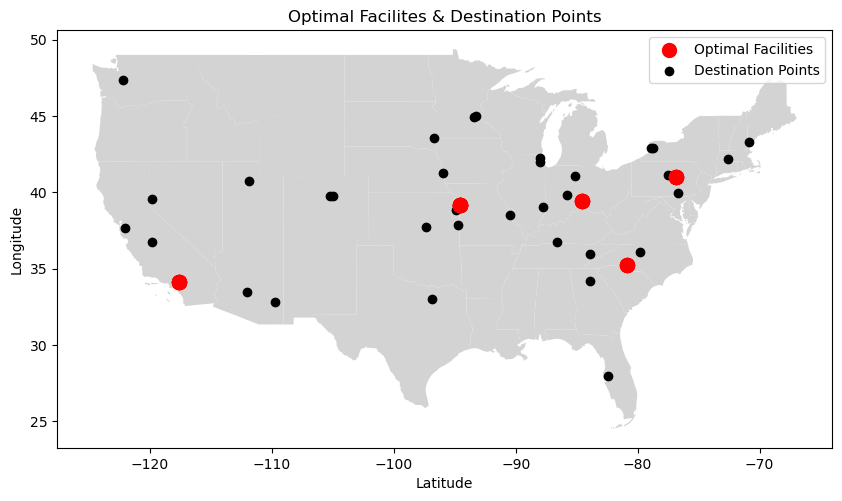

In [133]:
# Load US shapefile, change file path as needed
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

# Extract latitude and longitude from the geometry
us_map['Latitude'] = us_map['geometry'].centroid.y
us_map['Longitude'] = us_map['geometry'].centroid.x


fig, ax = plt.subplots(figsize=(10, 6))
us_map.plot(ax=ax, color='lightgrey')
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

# Scatter plot your data points
ax.scatter(merged_gdf['OriginLongitude'], merged_gdf['OriginLatitude'], color='red', label='Optimal Facilities', s = 100, zorder = 2)
ax.scatter(merged_gdf['DestLongitude'], merged_gdf['DestLatitude'], color='black', label='Destination Points', zorder = 1)

ax.legend()

plt.title('Optimal Facilites & Destination Points')
plt.show()

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/2107517839.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


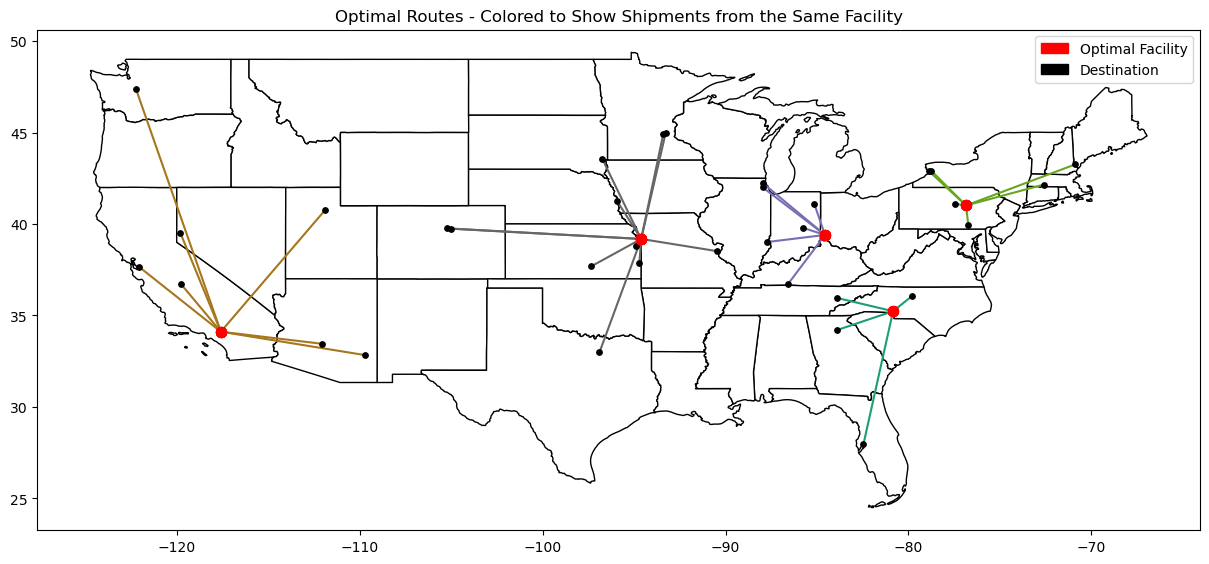

In [123]:
# get geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load US shapefile
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

ax = us_map.plot(color='white', edgecolor='black', figsize=(15, 10))
gdf_merged_destination.plot(ax=ax, color = 'black', markersize=15, zorder = 2)
merged_gdf.plot(ax=ax, column = 'Median', cmap = 'Dark2', zorder = 1)
gdf_merged_origin.plot(ax=ax, color='red', markersize=50, zorder = 3)

# Create legend
red_patch = mpatches.Patch(color='red', label='Optimal Facility')
black_patch = mpatches.Patch(color='black', label='Destination')
ax.legend(handles=[red_patch, black_patch])

plt.title('Optimal Routes - Colored to Show Shipments from the Same Facility')
plt.show()

## K Means Model for Comparison

We performed a k means model, since we wanted to compare the results of our custom model to one that is pre-packaged (k-means package from sklearn). We were curious how similar the results would be.

In [124]:
# assigning data for k means
k_data  = gdf[['DestLongitude', 'DestLatitude']]
k_data

,DestLongitude,DestLatitude
17895,-84.56,39.4
18020,-84.56,39.4
18021,-84.56,39.4
18116,-84.56,39.4
18214,-84.56,39.4
...,...,...
38486,-87.97,42.0
38489,-87.97,42.0
38495,-87.97,42.0
38496,-87.97,42.0


In [125]:
#clustering data
kmeans = KMeans(5)
kmeans.fit(k_data)

/Users/noascharf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

In [126]:
#predict cluster
identified_clusters = kmeans.fit_predict(k_data)
identified_clusters

/Users/noascharf/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [127]:
data_with_clusters = gdf.copy()
data_with_clusters['Cluster'] = identified_clusters
data_with_clusters.head()

,SCAC,OriginCity,OriginState,OriginLongitude,OriginLatitude,DestCity,DestState,DestLatitude,DestLongitude,OriginPoint,DestPoint,geometry,haversine_distance,demand_points,Cluster
17895,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56,POINT (-84.39 33.75),POINT (-84.56 39.4),"LINESTRING (-84.39000 33.75000, -84.56000 39.4...",390.495338,"(-84.56, 39.4)",0
18020,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56,POINT (-84.39 33.75),POINT (-84.56 39.4),"LINESTRING (-84.39000 33.75000, -84.56000 39.4...",390.495338,"(-84.56, 39.4)",0
18021,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56,POINT (-84.39 33.75),POINT (-84.56 39.4),"LINESTRING (-84.39000 33.75000, -84.56000 39.4...",390.495338,"(-84.56, 39.4)",0
18116,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56,POINT (-84.39 33.75),POINT (-84.56 39.4),"LINESTRING (-84.39000 33.75000, -84.56000 39.4...",390.495338,"(-84.56, 39.4)",0
18214,HJBT,ATLANTA,GA,-84.39,33.75,HAMILTON,OH,39.4,-84.56,POINT (-84.39 33.75),POINT (-84.56 39.4),"LINESTRING (-84.39000 33.75000, -84.56000 39.4...",390.495338,"(-84.56, 39.4)",0


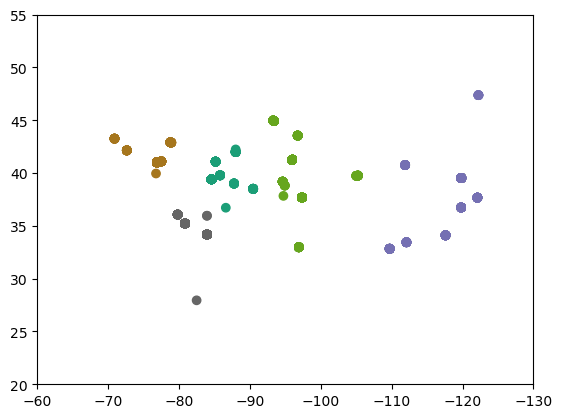

In [128]:
us_map = gpd.read_file("/Users/noascharf/Library/CloudStorage/OneDrive-Personal/Data Science/Spring 2024/DASC 3203 - Optimization/Project/cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

plt.scatter(gdf['DestLongitude'], gdf['DestLatitude'], c=data_with_clusters['Cluster'], cmap = 'Dark2')
plt.xlim(-60,-130)
plt.ylim(20, 55)
plt.show()

In [129]:
# putting points into numpy array for plotting
points = np.array(kmeans.cluster_centers_)
points

array([[ -85.50632911,   39.68516456],
       [-117.37619529,   37.13084175],
       [ -96.40333988,   40.13996071],
       [ -76.5428    ,   41.39866667],
       [ -82.30751825,   34.75271533]])

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/2945201606.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Latitude'] = us_map['geometry'].centroid.y
/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/2945201606.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Longitude'] = us_map['geometry'].centroid.x


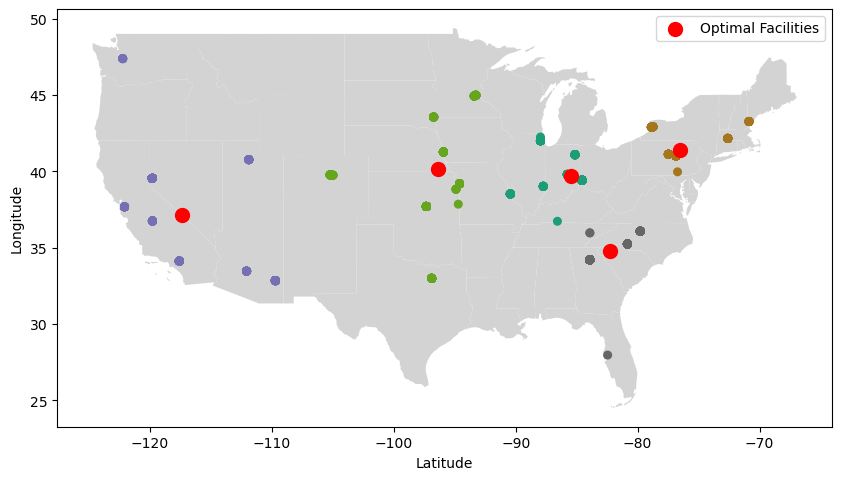

In [130]:
# Load US shapefile, change file path as needed
us_map = gpd.read_file("/Users/noascharf/Library/CloudStorage/OneDrive-Personal/Data Science/Spring 2024/DASC 3203 - Optimization/Project/cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

# Extract latitude and longitude from the geometry
us_map['Latitude'] = us_map['geometry'].centroid.y
us_map['Longitude'] = us_map['geometry'].centroid.x


fig, ax = plt.subplots(figsize=(10, 6))
us_map.plot(ax=ax, color='lightgrey')
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")

# Scatter plot your data points
ax.scatter(gdf['DestLongitude'], gdf['DestLatitude'], c=data_with_clusters['Cluster'], cmap = 'Dark2', s = 30)
ax.scatter(points[:, 0], points[:, 1], color='red', label='Optimal Facilities', s = 100)

ax.legend()

plt.show()

## Comparing Our Models

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/275143725.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Latitude'] = us_map['geometry'].centroid.y
/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/275143725.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  us_map['Longitude'] = us_map['geometry'].centroid.x


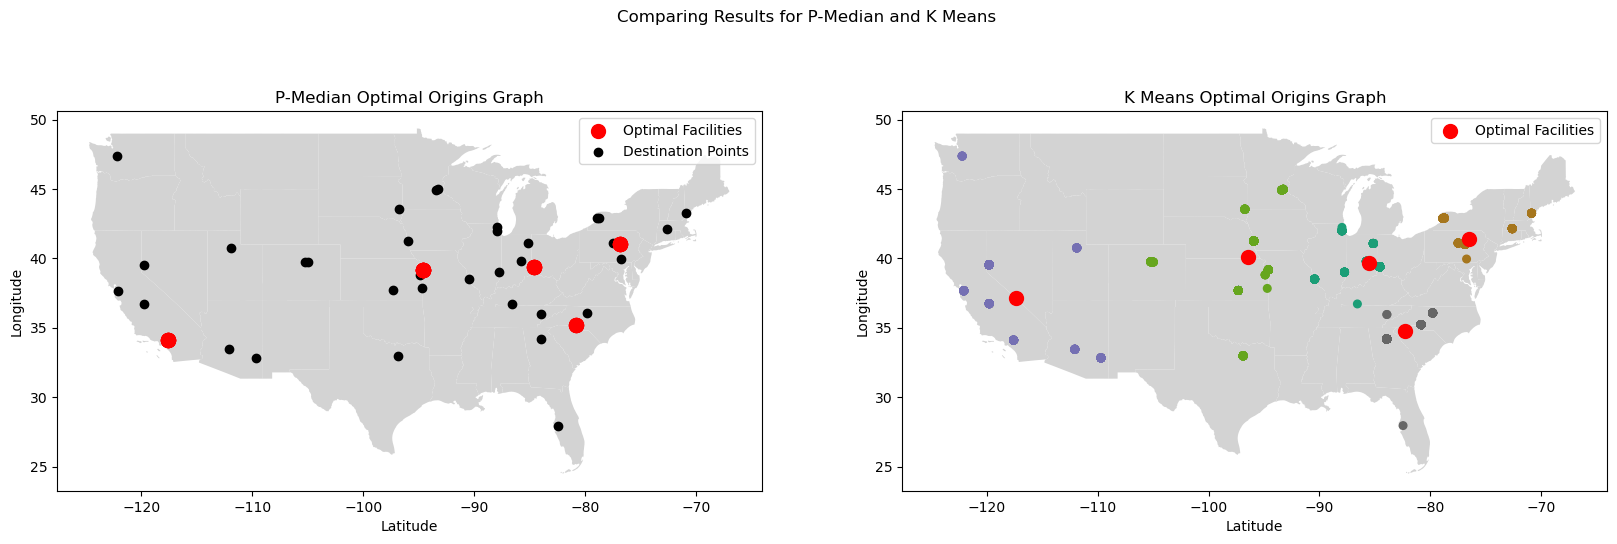

In [131]:
# Load US shapefile, change file path as needed
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

# Extract latitude and longitude from the geometry
us_map['Latitude'] = us_map['geometry'].centroid.y
us_map['Longitude'] = us_map['geometry'].centroid.x

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# First plot
us_map.plot(ax=ax1, color='lightgrey')
ax1.set_xlabel("Latitude")
ax1.set_ylabel("Longitude")
ax1.scatter(merged_gdf['OriginLongitude'], merged_gdf['OriginLatitude'], color='red', label='Optimal Facilities', s = 100, zorder = 2)
ax1.scatter(merged_gdf['DestLongitude'], merged_gdf['DestLatitude'], color='black', label='Destination Points', zorder = 1)
ax1.legend()

# Second plot
us_map.plot(ax=ax2, color='lightgrey')
ax2.set_xlabel("Latitude")
ax2.set_ylabel("Longitude")
ax2.scatter(gdf['DestLongitude'], gdf['DestLatitude'], c=data_with_clusters['Cluster'], cmap = 'Dark2', s = 30)
ax2.scatter(points[:, 0], points[:, 1], color='red', label='Optimal Facilities', s = 100)
ax2.legend()

ax1.set_title('P-Median Optimal Origins Graph')
ax2.set_title('K Means Optimal Origins Graph')
fig.suptitle('Comparing Results for P-Median and K Means')
plt.show()

Comparing the two models, we are shocked at the results. The locations that were chosen as optimal facilities for both of our models were super similar, which really excites us.

/var/folders/sq/sn1h0hns2t7b9w6qgdx378n80000gn/T/ipykernel_79859/2173332822.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


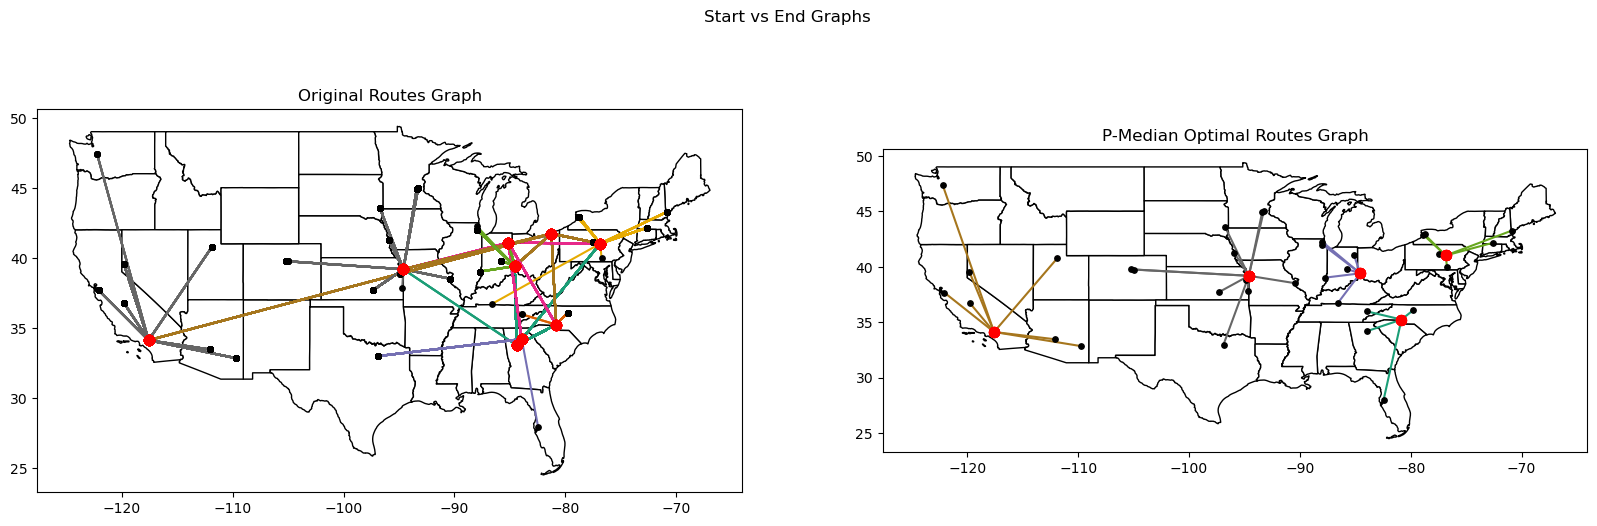

In [132]:
# get geospatial data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Load US shapefile
us_map = gpd.read_file("cb_2018_us_state_20m")
us_map = us_map[~us_map['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Convert CRS to EPSG 4326
us_map = us_map.to_crs(epsg=4326)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot the first graph
us_map.plot(ax=ax1, color='white', edgecolor='black')
gdf_origin.plot(ax=ax1, color='red', markersize=50, zorder = 3)
gdf_destination.plot(ax=ax1, color = 'black', markersize=15, zorder =2)
gdf.plot(ax=ax1, column = 'OriginCity', cmap = 'Dark2', zorder = 1)

# Plot the second graph
us_map.plot(ax=ax2, color='white', edgecolor='black')
gdf_merged_destination.plot(ax=ax2, color = 'black', markersize=15, zorder = 2)
merged_gdf.plot(ax=ax2, column = 'Median', cmap = 'Dark2', zorder = 1)
gdf_merged_origin.plot(ax=ax2, color='red', markersize=50, zorder = 3)

# Show the plots
ax1.set_title('Original Routes Graph')
ax2.set_title('P-Median Optimal Routes Graph')
fig.suptitle('Start vs End Graphs')
plt.show()


Comparing the routes that our data originally took, to the optimal routes that our model created, we are very happy with these results. One can clearly see that there have been some optimal changes made to minimize distance (for example, the cross country route on the original graph, is now not there in the optimal graph).